<a href="https://colab.research.google.com/github/uplus26e7/pytorch-programming-introduction/blob/master/%E5%8B%95%E3%81%8B%E3%81%97%E3%81%AA%E3%81%8C%E3%82%89%E5%AD%A6%E3%81%B6_PyTorch_%E3%83%97%E3%83%AD%E3%82%B0%E3%83%A9%E3%83%9F%E3%83%B3%E3%82%B0%E5%85%A5%E9%96%80_Chapter4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [45]:
import numpy as np
import glob
import os
import math
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch import nn
import torch.nn.functional as F
from torch import optim
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from PIL import Image
from sklearn.model_selection import train_test_split

# Section 2 CIFAR-10データセットの画像分類【サンプルコード】

## Section 2.2 訓練データとテストデータの用意

In [2]:
train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize(
                                      [0.5, 0.5, 0.5],
                                      [0.5, 0.5, 0.5]
                                  )
    ])
)

test_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize(
                                      [0.5, 0.5, 0.5],
                                      [0.5, 0.5, 0.5]
                                  )
    ])
)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
image, label = train_dataset[0]
image.size(), label

(torch.Size([3, 32, 32]), 6)

In [4]:
train_batch = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2
)

test_batch = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

for images, labels in train_batch:
  print(f"batch images size: {images.size()}")
  print(f"image size: {images[0].size()}")
  print(f"batch labels size: {labels.size()}")
  break


batch images size: torch.Size([64, 3, 32, 32])
image size: torch.Size([3, 32, 32])
batch labels size: torch.Size([64])


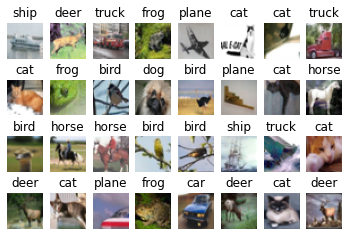

In [5]:
classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

for images, labels in train_batch:
  for i in range(32):
    image = images[i] / 2 + 0.5
    image = image.numpy()
    plt.subplot(4, 8, i + 1)
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.title(classes[labels[i]])
    plt.axis("off")
  plt.show()
  break

## Section 2.3 ニューラルネットワークの定義

In [6]:
num_classes = 10

class AlexNet(nn.Module):
  def __init__(self, num_classes=num_classes):
    super(AlexNet, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=7, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(64, 192, kernel_size=5, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(192, 384, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(384, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),
    )

    self.classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(256 * 3 * 3, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, num_classes),
    )
  
  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), 256 * 3 * 3)
    x = self.classifier(x)
    return x

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
net = AlexNet().to(device)
net

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=2304, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

## Section 2.4 損失関数と最適化関数の定義

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

## Section 2.5 学習

In [14]:
train_loss_list = []
test_loss_list = []
train_accuracy_list = []
test_accuracy_list = []

epoch = 10

for i in range(epoch):
  print("-" * 100)
  print(f"Epoch: {i + 1}/{epoch}")

  train_loss = 0
  test_loss = 0
  train_accuracy = 0
  test_accuracy = 0

  # train part
  net.train()
  for images, labels in train_batch:
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    y_pred_prob = net(images)
    loss = criterion(y_pred_prob, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    y_pred_labels = torch.max(y_pred_prob, 1)[1]
    train_accuracy += torch.sum(y_pred_labels == labels).item() / len(labels)
  
  epoch_train_loss = train_loss / len(train_batch)
  epoch_train_accuracy = train_accuracy / len(train_batch)

  # eval part
  net.eval()
  with torch.no_grad():
    for images, labels in test_batch:
      images = images.to(device)
      labels = labels.to(device)

      y_pred_prob = net(images)
      loss = criterion(y_pred_prob, labels)
      test_loss += loss.item()

      y_pred_labels = torch.max(y_pred_prob, 1)[1]
      test_accuracy += torch.sum(y_pred_labels == labels).item() / len(labels)
  
  epoch_test_loss = test_loss / len(test_batch)
  epoch_test_accuracy = test_accuracy / len(test_batch)

  print(f"Train_Loss: {epoch_train_loss:.4f}, Train_Accuracy: {epoch_train_accuracy:.4f}")
  print(f"Test_Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_accuracy:.4f}")

  train_loss_list.append(epoch_train_loss)
  test_loss_list.append(epoch_test_loss)
  train_accuracy_list.append(epoch_train_accuracy)
  test_accuracy_list.append(epoch_test_accuracy)

----------------------------------------------------------------------------------------------------
Epoch: 1/10
Train_Loss: 1.6940, Train_Accuracy: 0.3545
Test_Loss: 1.3952, Test Accuracy: 0.4887
----------------------------------------------------------------------------------------------------
Epoch: 2/10
Train_Loss: 1.3363, Train_Accuracy: 0.5158
Test_Loss: 1.2024, Test Accuracy: 0.5734
----------------------------------------------------------------------------------------------------
Epoch: 3/10
Train_Loss: 1.1652, Train_Accuracy: 0.5883
Test_Loss: 1.0933, Test Accuracy: 0.6167
----------------------------------------------------------------------------------------------------
Epoch: 4/10
Train_Loss: 1.0356, Train_Accuracy: 0.6351
Test_Loss: 1.0166, Test Accuracy: 0.6418
----------------------------------------------------------------------------------------------------
Epoch: 5/10
Train_Loss: 0.9442, Train_Accuracy: 0.6743
Test_Loss: 0.9321, Test Accuracy: 0.6826
---------------

## Section 2.6 結果の可視化

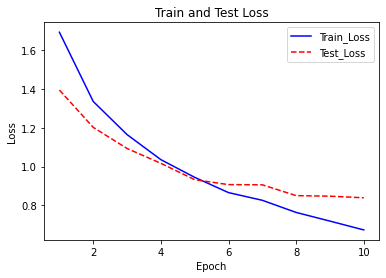

In [15]:
plt.figure()
plt.title("Train and Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(range(1, epoch + 1), train_loss_list, color="blue", linestyle="-", label="Train_Loss")
plt.plot(range(1, epoch + 1), test_loss_list, color="red", linestyle="--", label="Test_Loss")
plt.legend()
plt.show()

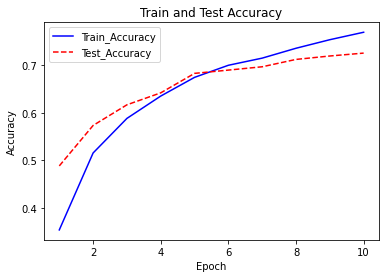

In [16]:
plt.figure()
plt.title("Train and Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(range(1, epoch + 1), train_accuracy_list, color="blue", linestyle="-", label="Train_Accuracy")
plt.plot(range(1, epoch + 1), test_accuracy_list, color="red", linestyle="--", label="Test_Accuracy")
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


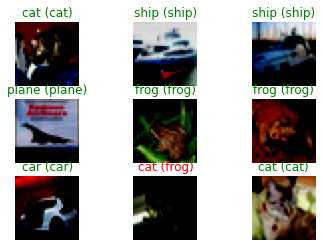

In [17]:
net.eval()

with torch.no_grad():
  for images, labels in test_batch:
    images = images.to(device)
    labels = labels.to(device)

    y_pred_prob = net(images)
    y_pred_labels = torch.max(y_pred_prob, 1)[1]

    for i in range(9):
      image = images[i]
      image = image.to("cpu").numpy()
      plt.subplot(3, 3, i + 1)
      plt.imshow(np.transpose(image, (1, 2, 0)))
      plt.title(f"{classes[y_pred_labels[i].item()]} ({classes[labels[i].item()]})", color=("green" if y_pred_labels[i] == labels[i] else "red"))
      plt.axis("off")
    plt.show()
    break

# Section 3 CIFAR-10データセットの転移学習【サンプルコード】

## Section 3.2 訓練データとテストデータの用意

In [23]:
train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transforms.Compose([
                                  transforms.Resize(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize(
                                      [0.5, 0.5, 0.5],
                                      [0.5, 0.5, 0.5]
                                  )
    ])
)

test_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transforms.Compose([
                                  transforms.Resize(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize(
                                      [0.5, 0.5, 0.5],
                                      [0.5, 0.5, 0.5]
                                  )
    ])
)

image, label = train_dataset[0]
image.size(), label

Files already downloaded and verified
Files already downloaded and verified


(torch.Size([3, 224, 224]), 6)

In [24]:
train_batch = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2
)

test_batch = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

for images, labels in train_batch:
  print(f"batch images size: {images.size()}")
  print(f"image size: {images[0].size()}")
  print(f"batch labels size: {labels.size()}")
  break

batch images size: torch.Size([64, 3, 224, 224])
image size: torch.Size([3, 224, 224])
batch labels size: torch.Size([64])


## Section 3.3 学習済みのニューラルネットワークの読み込み

In [27]:
net = models.alexnet(pretrained=True)
net = net.to(device)
net

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [30]:
for param in net.parameters():
  param.requires_grad = False
net = net.to(device)

In [31]:
num_features = net.classifier[6].in_features
num_classes = 10
net.classifier[6] = nn.Linear(num_features, num_classes).to(device)
net

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Section 3.4 損失関数と最適化関数の定義

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

## Section 3.5 学習

In [33]:
train_loss_list = []
test_loss_list = []
train_accuracy_list = []
test_accuracy_list = []

epoch = 10

for i in range(epoch):
  print("-" * 100)
  print(f"Epoch: {i + 1}/{epoch}")

  train_loss = 0
  test_loss = 0
  train_accuracy = 0
  test_accuracy = 0

  # train part
  net.train()
  for images, labels in train_batch:
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    y_pred_prob = net(images)
    loss = criterion(y_pred_prob, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    y_pred_labels = torch.max(y_pred_prob, 1)[1]
    train_accuracy += torch.sum(y_pred_labels == labels).item() / len(labels)
  
  epoch_train_loss = train_loss / len(train_batch)
  epoch_train_accuracy = train_accuracy / len(train_batch)

  # eval part
  net.eval()
  with torch.no_grad():
    for images, labels in test_batch:
      images = images.to(device)
      labels = labels.to(device)

      y_pred_prob = net(images)
      loss = criterion(y_pred_prob, labels)
      test_loss += loss.item()

      y_pred_labels = torch.max(y_pred_prob, 1)[1]
      test_accuracy += torch.sum(y_pred_labels == labels).item() / len(labels)
  
  epoch_test_loss = test_loss / len(test_batch)
  epoch_test_accuracy = test_accuracy / len(test_batch)

  print(f"Train_Loss: {epoch_train_loss:.4f}, Train_Accuracy: {epoch_train_accuracy:.4f}")
  print(f"Test_Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_accuracy:.4f}")

  train_loss_list.append(epoch_train_loss)
  test_loss_list.append(epoch_test_loss)
  train_accuracy_list.append(epoch_train_accuracy)
  test_accuracy_list.append(epoch_test_accuracy)

----------------------------------------------------------------------------------------------------
Epoch: 1/10
Train_Loss: 0.8818, Train_Accuracy: 0.6888
Test_Loss: 0.6919, Test Accuracy: 0.7525
----------------------------------------------------------------------------------------------------
Epoch: 2/10
Train_Loss: 0.7776, Train_Accuracy: 0.7274
Test_Loss: 0.6411, Test Accuracy: 0.7755
----------------------------------------------------------------------------------------------------
Epoch: 3/10
Train_Loss: 0.7631, Train_Accuracy: 0.7331
Test_Loss: 0.6731, Test Accuracy: 0.7676
----------------------------------------------------------------------------------------------------
Epoch: 4/10
Train_Loss: 0.7497, Train_Accuracy: 0.7373
Test_Loss: 0.6355, Test Accuracy: 0.7786
----------------------------------------------------------------------------------------------------
Epoch: 5/10
Train_Loss: 0.7460, Train_Accuracy: 0.7398
Test_Loss: 0.6486, Test Accuracy: 0.7700
---------------

## Section 3.6 結果の可視化

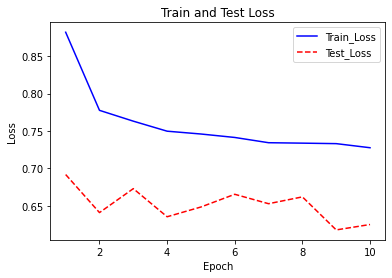

In [34]:
plt.figure()
plt.title("Train and Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(range(1, epoch + 1), train_loss_list, color="blue", linestyle="-", label="Train_Loss")
plt.plot(range(1, epoch + 1), test_loss_list, color="red", linestyle="--", label="Test_Loss")
plt.legend()
plt.show()

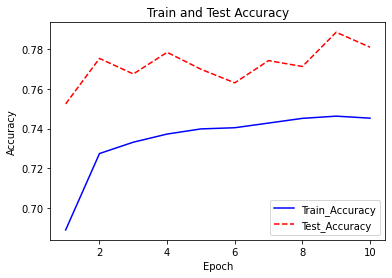

In [35]:
plt.figure()
plt.title("Train and Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(range(1, epoch + 1), train_accuracy_list, color="blue", linestyle="-", label="Train_Accuracy")
plt.plot(range(1, epoch + 1), test_accuracy_list, color="red", linestyle="--", label="Test_Accuracy")
plt.legend()
plt.show()

# Section 4 画像の高解像度化【サンプルコード】

## Section 4.2 画像データの準備(Labeled Faces in the Wild)

In [43]:
!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
!tar -xzf lfw-deepfunneled.tgz

--2021-01-10 09:22:09--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘lfw-deepfunneled.tgz’

lfw-deepfunneled.tg 100%[===================>] 103.72M  30.6MB/s    in 4.6s    

2021-01-10 09:22:13 (22.5 MB/s) - ‘lfw-deepfunneled.tgz’ saved [108761145/108761145]



## Section 4.4 訓練データとテストデータの用意

In [41]:
class DownSampleDataset(Dataset):
  def __init__(self, root, transform=None, highreso_size=128, lowreso_size=32):
    self.transform = transform
    self.highreso_resize = transforms.Resize(highreso_size)
    self.lowreso_resize = transforms.Resize(lowreso_size)

    self.image_paths = sorted(glob.glob(os.path.join(root + "/*/*jpg")))
    self.images_n = len(self.image_paths)
  
  def __len__(self):
    return self.images_n
  
  def __getitem__(self, index):
    path = self.image_paths[index]
    image = Image.open(path)

    highreso_image = self.highreso_resize(image)
    lowreso_image = self.highreso_resize(self.lowreso_resize(image))

    if self.transform:
      highreso_image = self.transform(highreso_image)
      lowreso_image = self.transform(lowreso_image)
    
    return highreso_image, lowreso_image

In [42]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(
                                    [0.5, 0.5, 0.5],
                                    [0.5, 0.5, 0.5]
                                )
])

In [44]:
dataset = DownSampleDataset("lfw-deepfunneled", transform=transform, highreso_size=128, lowreso_size=32)

len(dataset)

13233

In [46]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2)

len(train_dataset), len(test_dataset)

(10586, 2647)

In [47]:
train_batch = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2
)

test_batch = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

In [49]:
for highreso_images, lowreso_images in train_batch:
  print(f"batch highreso_images size: {highreso_images.size()}")
  print(f"highreso image size: {highreso_images[0].size()}")
  print(f"batch lowreso_images size: {lowreso_images.size()}")
  print(f"lowreso image size: {lowreso_images[0].size()}")
  break

batch highreso_images size: torch.Size([64, 3, 128, 128])
highreso image size: torch.Size([3, 128, 128])
batch lowreso_images size: torch.Size([64, 3, 128, 128])
lowreso image size: torch.Size([3, 128, 128])


In [51]:
def cat_imshow(x, y, images1, images2, images3=None):
  plt.figure(figsize=(9, 7))
  for i in range(x*y):
    if i <= 3:
      images = images1
      image = images[i] / 2 + 0.5
    elif i > 3 and i <= 7:
      images = images2
      image = images[i - 4] / 2 + 0.5
    elif images3 != None:
      images = images3
      image = images[i - 8] / 2 + 0.5
    
    image = image.numpy()
    plt.subplot(x, y, i + 1)
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.axis("off")
    plt.subplots_adjust(wspace=0, hspace=0)
  plt.show()

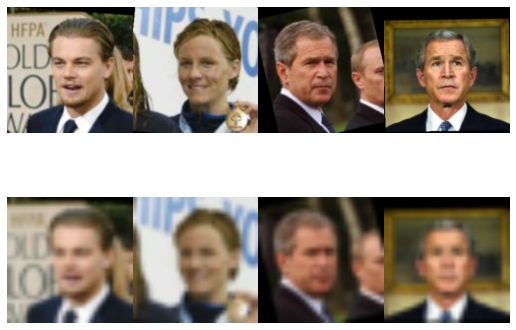

In [53]:
for highreso_images, lowreso_images in train_batch:
  cat_imshow(2, 4, highreso_images, lowreso_images)
  break

## Section 4.5 ニューラルネットワークの定義

In [54]:
class SRCNN(nn.Module):
  def __init__(self):
    super(SRCNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, padding=4)
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1, padding=0)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=5, padding=2)
  
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.conv3(x)
    return x

net = SRCNN().to(device)
net

SRCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)

## Section 4.6 損失関数と最適化関数の定義

In [56]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters())

## Section 4.7 学習

In [57]:
def calc_psnr_ssim(img1, img2, data_range=1):
  dim = len(img1.size())
  img1 = img1.to("cpu").detach().numpy()
  img2 = img2.to("cpu").detach().numpy()

  if dim == 3:
    img1 = np.transpose(img1, (1, 2, 0))
    img2 = np.transpose(img2, (1, 2, 0))
    psnr = peak_signal_noise_ratio(img1, img2, data_range=data_range)
    ssim = structural_similarity(img1, img2, multichannel=True, data_range=data_range)
    return psnr, ssim
  
  else:
    img1 = np.transpose(img1, (0, 2, 3, 1))
    img2 = np.transpose(img2, (0, 2, 3, 1))

    all_psnr = 0
    all_ssim = 0

    n_batchs = img1.shape[0]

    for i in range(n_batchs):
      psnr = peak_signal_noise_ratio(img1[i], img2[i], data_range=data_range)
      ssim = structural_similarity(img1[i], img2[i], multichannel=True, data_range=data_range)
      all_psnr += psnr
      all_ssim += ssim
    
    mean_psnr = all_psnr / n_batchs
    mean_ssim = all_ssim / n_batchs
    return mean_psnr, mean_ssim

In [58]:
for highreso_images, lowreso_images in train_batch:
  psnr, ssim = calc_psnr_ssim(highreso_images[i], lowreso_images[i], data_range=1)
  batch_psnr, batch_ssim = calc_psnr_ssim(highreso_images, lowreso_images, data_range=1)
  print(f"SINGLE PSNR: {psnr:.4f}, SSIM: {ssim:.4f}")
  print(f"BATCH PSNR: {batch_psnr:.4f}, SSIM: {batch_ssim:.4f}")
  break

SINGLE PSNR: 15.9738, SSIM: 0.5943
BATCH PSNR: 17.8936, SSIM: 0.6756


In [60]:
train_loss_list = []
test_loss_list = []
train_psnr_list = []
test_psnr_list = []
train_ssim_list = []
test_ssim_list = []

epoch = 100

for i in range(epoch):
  print("-" * 100)
  print(f"Epoch: {i + 1}/{epoch}")

  train_loss = 0
  test_loss = 0
  train_psnr = 0
  test_psnr = 0
  train_ssim = 0
  test_ssim = 0

  # train part
  net.train()
  for highreso_images, lowreso_images in train_batch:
    highreso_images = highreso_images.to(device)
    lowreso_images = lowreso_images.to(device)

    optimizer.zero_grad()
    y_pred = net(lowreso_images)
    loss = criterion(y_pred, highreso_images)
    psnr, ssim = calc_psnr_ssim(y_pred, highreso_images)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    train_psnr += psnr
    train_ssim += ssim

  batch_train_loss = train_loss / len(train_batch)
  batch_train_psnr = train_psnr / len(train_batch)
  batch_train_ssim = train_ssim / len(train_batch)

  # eval part
  net.eval()
  with torch.no_grad():
    for highreso_images, lowreso_images in test_batch:
      highreso_images = highreso_images.to(device)
      lowreso_images = lowreso_images.to(device)

      y_pred = net(lowreso_images)
      loss = criterion(y_pred, highreso_images)
      psnr, ssim = calc_psnr_ssim(y_pred, highreso_images)
      test_loss += loss.item()
      test_psnr += psnr
      test_ssim += ssim

  batch_test_loss = test_loss / len(test_batch)
  batch_test_psnr = test_psnr / len(test_batch)
  batch_test_ssim = test_ssim / len(test_batch)

  print(f"Train_Loss: {batch_train_loss:.4f}, Train_PSNR: {batch_train_psnr:.4f}, Train_SSIM: {batch_train_ssim:.4f}")
  print(f"Test_Loss: {batch_test_loss:.4f}, Test_PSNR: {batch_test_psnr:.4f}, Test_SSIM: {batch_test_ssim:.4f}")

  train_loss_list.append(batch_train_loss)
  test_loss_list.append(batch_test_loss)
  train_psnr_list.append(batch_train_psnr)
  test_psnr_list.append(batch_test_psnr)
  train_ssim_list.append(batch_train_ssim)
  test_ssim_list.append(batch_test_ssim)

----------------------------------------------------------------------------------------------------
Epoch: 1/100
Train_Loss: 0.0344, Train_PSNR: 16.0301, Train_SSIM: 0.5805
Test_Loss: 0.0151, Test_PSNR: 18.4831, Test_SSIM: 0.6885
----------------------------------------------------------------------------------------------------
Epoch: 2/100
Train_Loss: 0.0134, Train_PSNR: 19.0799, Train_SSIM: 0.7162
Test_Loss: 0.0123, Test_PSNR: 19.4044, Test_SSIM: 0.7357
----------------------------------------------------------------------------------------------------
Epoch: 3/100
Train_Loss: 0.0117, Train_PSNR: 19.6889, Train_SSIM: 0.7454
Test_Loss: 0.0112, Test_PSNR: 19.8320, Test_SSIM: 0.7533
----------------------------------------------------------------------------------------------------
Epoch: 4/100
Train_Loss: 0.0107, Train_PSNR: 20.0467, Train_SSIM: 0.7586
Test_Loss: 0.0105, Test_PSNR: 20.1215, Test_SSIM: 0.7633
----------------------------------------------------------------------------

## Section 4.8 結果の可視化

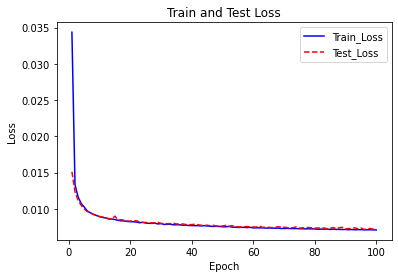

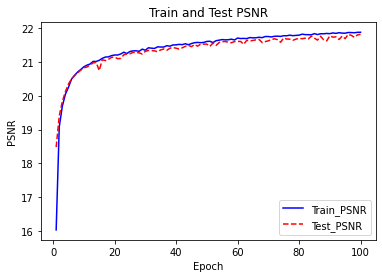

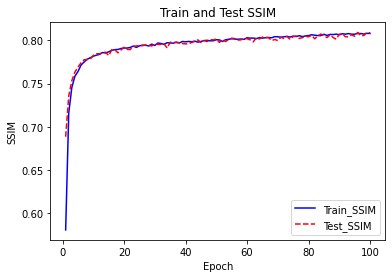

In [61]:
plt.figure()
plt.title("Train and Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(range(1, epoch + 1), train_loss_list, color="blue", linestyle="-", label="Train_Loss")
plt.plot(range(1, epoch + 1), test_loss_list, color="red", linestyle="--", label="Test_Loss")
plt.legend()

plt.figure()
plt.title("Train and Test PSNR")
plt.xlabel("Epoch")
plt.ylabel("PSNR")
plt.plot(range(1, epoch + 1), train_psnr_list, color="blue", linestyle="-", label="Train_PSNR")
plt.plot(range(1, epoch + 1), test_psnr_list, color="red", linestyle="--", label="Test_PSNR")
plt.legend()

plt.figure()
plt.title("Train and Test SSIM")
plt.xlabel("Epoch")
plt.ylabel("SSIM")
plt.plot(range(1, epoch + 1), train_ssim_list, color="blue", linestyle="-", label="Train_SSIM")
plt.plot(range(1, epoch + 1), test_ssim_list, color="red", linestyle="--", label="Test_SSIM")
plt.legend()

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Lowreso vs Highreso, PSNR: 17.4198, SSIM: 0.6668
DL_recon vs Highreso, PSNR: 21.7904, SSIM: 0.8100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


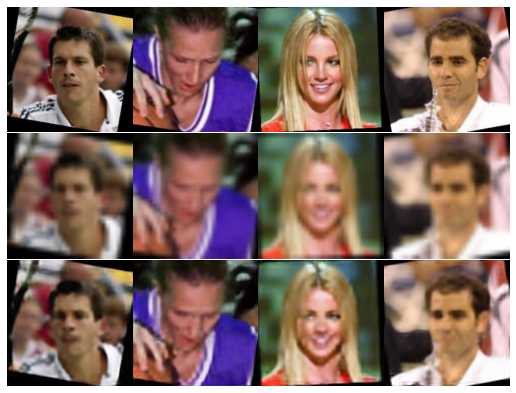

In [63]:
net.eval()

with torch.no_grad():
  for highreso_images, lowreso_images in test_batch:
    highreso_images = highreso_images.to(device)
    lowreso_images = lowreso_images.to(device)

    y_pred = net(lowreso_images)
    psnr1, ssim1 = calc_psnr_ssim(lowreso_images, highreso_images)
    psnr2, ssim2 = calc_psnr_ssim(y_pred, highreso_images)
    print(f"Lowreso vs Highreso, PSNR: {psnr1:.4f}, SSIM: {ssim1:.4f}")
    print(f"DL_recon vs Highreso, PSNR: {psnr2:.4f}, SSIM: {ssim2:.4f}")

    cat_imshow(3, 4, highreso_images.to("cpu"), lowreso_images.to("cpu"), y_pred.to("cpu"))
    plt.show()
    break